In [1]:
import itertools
import os

import geopandas as gpd
import matplotlib.pyplot as plt
import nivapy3 as nivapy
import numpy as np
import pandas as pd
import seaborn as sn
import statsmodels.api as sm
import statsmodels.formula.api as smf
from osgeo import gdal
from rasterstats import zonal_stats
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm

plt.style.use("ggplot")

# Task 2.4: Calculate residence times

From the proposal text:

> **Oppgave 2.4: Beregne oppholdstider**
>
> NVEs innsjødybdedatabase skal brukes til å utvikle en statistisk modell som kan forutsi innsjøvolum (og dermed oppholdstid). Standardtilnærmingen vil bruke en regresjon av gjennomsnittlig vanndybde mot innsjøarealet (som i den opprinnelige TEOTIL modellen). Ytterligere kovariater, slik som gjennomsnittlig helning og høyde, vil også bli utforsket for å lage en mer robust statistisk modell, hvis mulig. Tilpasset regresjon vil bli brukt til å estimere innsjøvolum og oppholdstid for innsjøer langs hovedelver i hvert reginefelt. En Jupyter-notisbok som dokumenterer den statistiske utforskningen vil bli lagt til TEOTILs dokumentasjon.




## 1. Estimate lake volume

### 1.1. Read NVE's lake depth dataset

In [2]:
data_year = 2022
data_fold = f"/home/jovyan/shared/teotil3/core_data_june_{data_year}"

nve_gdb = os.path.join(data_fold, "hydrology", "NVEData.gdb")
dep_gdf = gpd.read_file(nve_gdb, driver="fileGDB", layer="InnsjoDybdedata").to_crs(
    "epsg:25833"
)

# Pretty sure 'omkrets_m' in the NVE data should actually be 'omkrets_km'
cols = [
    "vatnLnr",
    "innsjoAreal_km2",
    "omkrets_m",
    "middelDyp_m",
    "maksDyp_m",
    "volum_Mm3",
    "oppholdstid_Aar",
    "vassdragsnummer",
    "geometry",
]
new_cols = [
    "vatnLnr",
    "area_km2",
    "circum_km",
    "avg_dep_m",
    "max_dep_m",
    "vol_Mm3",
    "res_time_yr",
    "regine",
    "geometry",
]
dep_gdf = dep_gdf[cols]
dep_gdf.columns = new_cols
dep_gdf.head()

,vatnLnr,area_km2,circum_km,avg_dep_m,max_dep_m,vol_Mm3,res_time_yr,regine,geometry
0,2,51.00,0.00,190.0,460.0,9700.000,2.897308,016.G11,"MULTIPOLYGON (((152786.800 6666648.948, 152805..."
1,3,78.51,206.62,20.0,68.5,1573.523,1.000000,016.J11,"MULTIPOLYGON (((104358.251 6675071.184, 104375..."
2,6,58.40,0.00,87.0,171.0,5100.000,0.609125,016.B3,"MULTIPOLYGON (((174009.800 6597685.339, 174017..."
3,7,18.70,0.00,67.0,152.0,1260.000,0.390202,016.BB11,"MULTIPOLYGON (((141357.040 6591615.078, 141351..."
4,8,13.80,0.00,92.0,201.0,1280.000,0.412603,016.BB11,"MULTIPOLYGON (((139013.050 6593849.708, 139016..."


### 1.2. Data cleaning and checking

The raw NVE dataset contains some strange values e.g. the `avg_dep_m` and `vol_Mm3` columns include zero and negative values, which don't make sense. There is also one very large outlier (`vatnLnr = 3180`) with an area of 0.32 km2 and a volume of 1 435 361 Mm3. This must be an error - perhaps it should be 1.435361 Mm3? I'll remove these for now.

In [3]:
dep_gdf.describe()

,vatnLnr,area_km2,circum_km,avg_dep_m,max_dep_m,vol_Mm3,res_time_yr
count,686.000000,6.860000e+02,564.000000,578.000000,683.000000,5.730000e+02,563.000000
mean,12341.546647,1.737587e+04,7.089840,16.385744,50.674802,2.919201e+03,2.947238
std,22415.754946,2.081581e+05,21.290732,26.424021,59.266494,6.000532e+04,51.281182
min,2.000000,5.390000e-03,0.000000,-1.000000,0.000000,-1.000000e+00,0.000000
25%,709.500000,3.700000e-01,0.000000,0.000000,18.000000,0.000000e+00,0.000000
50%,2036.500000,1.200000e+00,0.000000,8.000000,34.500000,8.825000e+00,0.149859
75%,22376.500000,4.137500e+00,8.172500,20.000000,59.000000,5.122100e+01,0.651000
max,205467.000000,3.854618e+06,320.320000,237.000000,514.000000,1.435361e+06,1216.693000


In [4]:
# Remove odd data
dep_gdf = dep_gdf.query(
    "(vol_Mm3 > 0) and (avg_dep_m > 0) and (vatnLnr != 3180) and (vol_Mm3 < 50000)"
).dropna(subset=["area_km2", "avg_dep_m", "vol_Mm3"])
print(len(dep_gdf), "lakes with valid average depth and volume measurements.")

392 lakes with valid average depth and volume measurements.


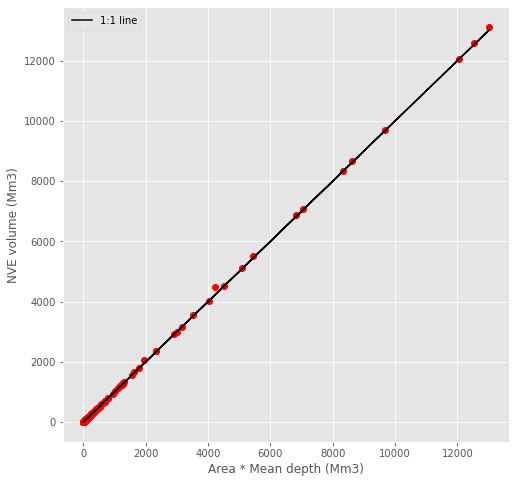

In [5]:
# Confirm that NVE's volume estimates are consistent with area * avg_vol
dep_gdf["vol2_Mm3"] = dep_gdf["area_km2"] * dep_gdf["avg_dep_m"]
dep_gdf["vol_ratio"] = dep_gdf["vol_Mm3"] / dep_gdf["vol2_Mm3"]

poss_nve_errors = dep_gdf.query("vol_ratio > 2")
if len(poss_nve_errors) > 0:
    print(
        "NVE's volume estimates for some lakes do not match their reported area and mean depth values."
    )
    display(poss_nve_errors)

fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(dep_gdf["vol2_Mm3"], dep_gdf["vol_Mm3"], "ro")
ax.plot(dep_gdf["vol2_Mm3"], dep_gdf["vol2_Mm3"], "k-", label="1:1 line")
ax.set_xlabel("Area * Mean depth (Mm3)")
ax.set_ylabel("NVE volume (Mm3)")
ax.legend(loc="upper left")

del dep_gdf["vol2_Mm3"], dep_gdf["vol_ratio"]

### 1.3. Calculate parameters of interest

In addition to the raw data in the NVE database, there are many additional parameters/characteristics that could be useful for predicting lake volume. In order for statistical tests to be fair, it is important that all models and methods are evaluated using the same data. In this section, I will therefore derive all parameters (i.e possible covariates) used by the models under consideration to create a single dataset that can be used for model comparison and evaluation.

#### 1.3.1. Lake shape

In boreal landscapes that have been strongly influenced by glacial processes, long, narrow lakes are often deeper than those with more equal aspect ratios, because they occupy deeply incised former river valleys or glacial troughs. The **aspect ratio** of a lake may therefore be a useful predictor of mean depth.

Aspect ratio is defined as the ratio of length to width. For arbitrary shapes such as lakes, length is typically defined as the longest straight line measured shoreline-to-shoreline across the surface, and width is taken to be the longest shoreline-to-shoreline distance perpendicular to the length (see e.g. [here](https://www.lakescientist.com/lake-shape/)). However, algorithms for calculating these quantities for generic polygons are fiddly and computationally intensive.

An alternative - and equally valid - definition for width and length can be obtained by modelling each lake as a rectangle with the same perimeter and area as the original lake polygon. Consider a rectangle of length $l$ and width $w$. The perimeter is $P = 2l + 2w$ and the area is $A = lw$. By substituting for $l$ we obtain the quadratic

$$P = \frac{2A}{w} + 2w$$

or 

$$2w^2 - Pw + 2A = 0$$

This can be solved using the quadratic formula to give

$$w = \frac{P - \sqrt{P^2 - 16A}}{4}$$

and 

$$l = \frac{P + \sqrt{P^2 - 16A}}{4}$$

For arbitrary elongated shapes, these equations can be therefore be used as reasonable *definitions* for length and width, from which aspect ratio can be calculated.

**Note:** For a square, $P^2 = 16A$, so $l = w = \frac{P}{4}$, which is correct. However, this approach will give complex output for any shape where $16A > P^2$ (e.g. circles). In such cases, it is probably sensible to model circles as squares with either the same area or the same perimeter as the original circle. This is not usually an issue for irregular objects like lakes, so in the code below I've simply added a check to ensure all results are real.

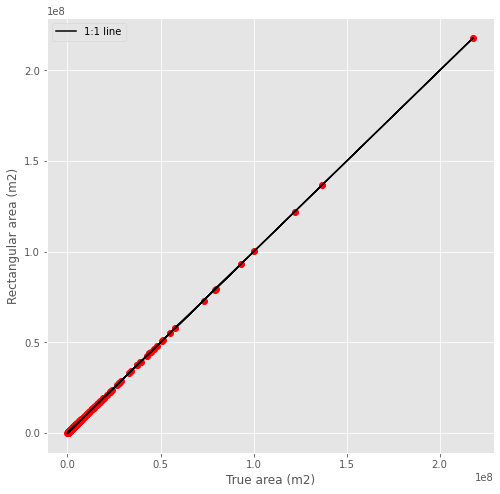

In [6]:
# Calculate perimeter and area in m
dep_gdf["perim_m"] = dep_gdf["geometry"].length
dep_gdf["area_m2"] = dep_gdf["geometry"].area

# Calculate 'width' and 'length'
dep_gdf["width_m"] = (
    dep_gdf["perim_m"] - (dep_gdf["perim_m"] ** 2 - 16 * dep_gdf["area_m2"]) ** 0.5
) / 4
dep_gdf["length_m"] = (
    dep_gdf["perim_m"] + (dep_gdf["perim_m"] ** 2 - 16 * dep_gdf["area_m2"]) ** 0.5
) / 4

dep_gdf["aspect_ratio"] = dep_gdf["length_m"] / dep_gdf["width_m"]

assert np.iscomplex(dep_gdf["width_m"]).sum() == 0
assert np.iscomplex(dep_gdf["length_m"]).sum() == 0

# Check w * l = A
dep_gdf["area2_m2"] = dep_gdf["width_m"] * dep_gdf["length_m"]
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(dep_gdf["area2_m2"], dep_gdf["area_m2"], "ro")
ax.plot(dep_gdf["area2_m2"], dep_gdf["area2_m2"], "k-", label="1:1 line")
ax.set_xlabel("True area (m2)")
ax.set_ylabel("Rectangular area (m2)")
ax.legend(loc="upper left")
del dep_gdf["perim_m"], dep_gdf["area_m2"], dep_gdf["area2_m2"]

dep_gdf.dropna(subset="aspect_ratio", inplace=True)

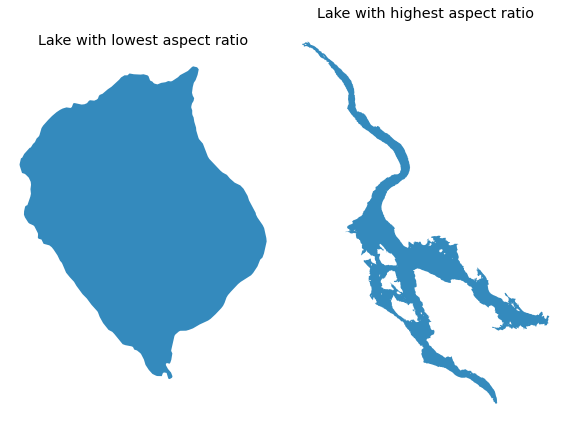

In [7]:
# Plot lakes with low and high aspect ratios
fig, axes = plt.subplots(ncols=2, figsize=(8, 8))
dep_gdf.sort_values("aspect_ratio").iloc[[0]].plot(ax=axes[0])
dep_gdf.sort_values("aspect_ratio").iloc[[-1]].plot(ax=axes[1])
axes[0].set_title("Lake with lowest aspect ratio")
axes[1].set_title("Lake with highest aspect ratio")
axes[0].axis("off")
axes[1].axis("off")
plt.tight_layout()

#### 1.3.2. Terrain characteristics

Landscape characteristics in the vicinity of a lake may give clues about the bathymetry. An obvious way to approach this is to **buffer** the lake polygons by some width, $b$, and then use zonal statistics to calculate terrain properties (e.g. slope and elevation characteristics) within a strip of width $b$ around each lake's margin. The code below calculates min, mean, max, std. dev., median and percentiles for both elevations (in metres) and slopes (in degrees) in the regions around the edge of each lake. Furthermore, following [Heathcoate et al. (2015)](https://cdnsciencepub.com/doi/10.1139/cjfas-2014-0392), I have calculated the mean elevation change in the buffered zone (estimated as $mean\_elevation - min\_elevation$). The justification for this is that the mean topography in the area around a lake may be a good predictor of the mean topography below the surface.

For the buffering, some authors (e.g. [Heathcoate et al., 2015](https://cdnsciencepub.com/doi/10.1139/cjfas-2014-0392)) used a buffer distance proportional to the lake size (rather than a fixed value, as used by e.g. [Sobek et al., 2011](https://www.diva-portal.org/smash/get/diva2:574714/FULLTEXT02.pdf)), under the assumption that the bathymetry of larger lakes is probably best represented by a similarly large part of the surrounding landscape. This seems reasonable, but Heathcoate et al. suggested the buffer distance should be 25% of the equivalent diameter, $D$, of the lake, where $D = 2 \sqrt{\frac{A}{\pi}}$ and $A$ is the lake's surface area. This seems pretty arbitrary, so in the code below I've used my lake width estimate from above instead (which I think has a better physical basis).

In [8]:
dtm_res = 40
buffer = dep_gdf["width_m"]  # 500  # metres or pandas Series
temp_fold = r"/home/jovyan/shared/01_datasets/spatial/temp"

In [9]:
# Get vassom from regine code
dep_gdf["vassom"] = dep_gdf["regine"].str[:3]
reg_list = dep_gdf["regine"].unique().tolist()
vassom_list = dep_gdf["vassom"].unique().tolist()
print(
    f"The depth dataset includes lakes from {len(reg_list)} regines in {len(vassom_list)} vassdragsområder."
)

The depth dataset includes lakes from 356 regines in 113 vassdragsområder.


In [10]:
# Buffer lakes and clip to create zone dataset
zone_gdf = dep_gdf.copy()
zone_gdf["geometry"] = zone_gdf.buffer(buffer)
zone_gdf = zone_gdf.overlay(dep_gdf, how="difference")
zone_gdf.head()

,vatnLnr,area_km2,circum_km,avg_dep_m,max_dep_m,vol_Mm3,res_time_yr,regine,geometry,width_m,length_m,aspect_ratio,vassom
0,2,51.00,0.00,190.0,460.0,9700.000,2.897308,016.G11,"MULTIPOLYGON (((151168.014 6665899.461, 151168...",1065.615031,48386.562316,45.407169,016
1,3,78.51,206.62,20.0,68.5,1573.523,1.000000,016.J11,"MULTIPOLYGON (((103129.169 6674955.435, 103136...",744.310951,106268.972071,142.774968,016
2,6,58.40,0.00,87.0,171.0,5100.000,0.609125,016.B3,"MULTIPOLYGON (((168681.214 6595907.785, 168671...",781.011016,70570.271405,90.357588,016
3,7,18.70,0.00,67.0,152.0,1260.000,0.390202,016.BB11,"MULTIPOLYGON (((140350.411 6592624.693, 140365...",746.907448,26240.470290,35.132158,016
4,8,13.80,0.00,92.0,201.0,1280.000,0.412603,016.BB11,"MULTIPOLYGON (((130576.973 6599980.560, 130570...",733.598668,21490.154133,29.294156,016


In [11]:
# Zonal stats for catchments
stats = [
    "min",
    "percentile_25",
    "median",
    "percentile_75",
    "max",
    "mean",
    "std",
    "count",
]

# Process each vassom in turn
df_list = []
for vassom in tqdm(vassom_list):
    dem_path = f"/home/jovyan/shared/01_datasets/spatial/dtm_merged_utm33/dtm_{dtm_res}m/by_vassom/dtm/vassom_{vassom}_{dtm_res}m_dtm.tif"
    slp_path = os.path.join(temp_fold, f"vassom_{vassom}_{dtm_res}m_slope.tif")
    vassom_zone_gdf = zone_gdf.query("vassom == @vassom").dropna(subset="geometry")

    # Calcule slopes
    gdal.DEMProcessing(
        slp_path,
        dem_path,
        "slope",
        alg="Horn",  # 'Horn' or 'ZevenbergenThorne'
        slopeFormat="degree",  # 'degree' or 'percent'
        creationOptions=["compress=lzw", "BIGTIFF=YES", "tiled=True"],
    )

    # Zonal stats
    idx_cols = [i for i in vassom_zone_gdf.columns if i != "geometry"]
    slp_stats = [f"slp_{i}" for i in stats]
    dem_stats = [f"dem_{i}" for i in stats]
    cols = idx_cols + slp_stats + dem_stats + ["geometry"]
    slp_res_df = pd.DataFrame(
        zonal_stats(
            vectors=vassom_zone_gdf,
            raster=slp_path,
            stats=stats,
        )
    )

    dem_res_df = pd.DataFrame(
        zonal_stats(
            vectors=vassom_zone_gdf,
            raster=dem_path,
            stats=stats,
        )
    )

    # Tidy
    assert len(vassom_zone_gdf) == len(slp_res_df)
    assert len(vassom_zone_gdf) == len(dem_res_df)

    for col in slp_res_df.columns:
        vassom_zone_gdf["slp_" + col] = slp_res_df[col].values
    for col in dem_res_df.columns:
        vassom_zone_gdf["dem_" + col] = dem_res_df[col].values

    vassom_zone_gdf = vassom_zone_gdf[cols]
    vassom_zone_gdf.dropna(subset=slp_stats + dem_stats, inplace=True)
    vassom_zone_gdf.rename(
        {
            "slp_percentile_25": "slp_p25",
            "slp_percentile_75": "slp_p75",
            "dem_percentile_25": "dem_p25",
            "dem_percentile_75": "dem_p75",
        },
        axis="columns",
        inplace=True,
    )
    df_list.append(vassom_zone_gdf)
    os.remove(slp_path)

# Combine results
stats_gdf = pd.concat(df_list, axis="rows")
stats_gdf["delta_elev"] = stats_gdf["dem_mean"] - stats_gdf["dem_min"]
print(len(stats_gdf), "lakes with complete data for all variables of interest.")

# Save to CSV
stats_csv = f"../../data/lake_volume_characteristics_{dtm_res}m_dem.csv"
pd.DataFrame(stats_gdf.drop(columns="geometry")).to_csv(stats_csv, index=False)

stats_gdf.head()

  0%|          | 0/113 [00:00<?, ?it/s]

389 lakes with complete data for all variables of interest.


,vatnLnr,area_km2,circum_km,avg_dep_m,max_dep_m,vol_Mm3,res_time_yr,regine,width_m,length_m,...,dem_min,dem_p25,dem_median,dem_p75,dem_max,dem_mean,dem_std,dem_count,geometry,delta_elev
0,2,51.00,0.00,190.0,460.0,9700.000,2.897308,016.G11,1065.615031,48386.562316,...,182.917572,273.750092,399.776459,532.362671,1135.659180,420.591094,172.600664,57649,"MULTIPOLYGON (((151168.014 6665899.461, 151168...",237.673522
1,3,78.51,206.62,20.0,68.5,1573.523,1.000000,016.J11,744.310951,106268.972071,...,884.538452,934.446594,958.549194,1010.426987,1366.511475,984.907791,72.298749,65178,"MULTIPOLYGON (((103129.169 6674955.435, 103136...",100.369339
2,6,58.40,0.00,87.0,171.0,5100.000,0.609125,016.B3,781.011016,70570.271405,...,3.569922,38.782055,63.614113,97.019167,401.084564,78.197858,59.192793,45012,"MULTIPOLYGON (((168681.214 6595907.785, 168671...",74.627936
3,7,18.70,0.00,67.0,152.0,1260.000,0.390202,016.BB11,746.907448,26240.470290,...,70.361526,112.268265,177.505035,268.061913,605.302551,203.993151,111.216413,22412,"MULTIPOLYGON (((140350.411 6592624.693, 140365...",133.631625
4,8,13.80,0.00,92.0,201.0,1280.000,0.412603,016.BB11,733.598668,21490.154133,...,71.938477,115.389778,179.942505,290.542038,799.089966,216.921346,126.325433,16579,"MULTIPOLYGON (((130576.973 6599980.560, 130570...",144.982870


### 1.4. Statistical models for lake volume

In [12]:
# Read saved data for speed
stats_csv = f"../../data/lake_volume_characteristics_{dtm_res}m_dem.csv"
stats_df = pd.read_csv(stats_csv)
stats_df.describe()

,vatnLnr,area_km2,circum_km,avg_dep_m,max_dep_m,vol_Mm3,res_time_yr,width_m,length_m,aspect_ratio,...,slp_count,dem_min,dem_p25,dem_median,dem_p75,dem_max,dem_mean,dem_std,dem_count,delta_elev
count,389.000000,389.000000,384.000000,389.000000,389.000000,389.000000,385.000000,389.000000,389.000000,389.000000,...,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000,389.000000
mean,9441.879177,6.893268,8.625104,23.466761,60.516941,418.376330,1.060791,445.240499,9816.863830,20.246965,...,7495.043702,371.769573,402.632980,430.643999,472.853637,639.487047,443.762268,51.802512,7495.043702,71.992696
std,14003.742928,18.183628,19.175894,28.619481,65.960125,1559.617264,2.224189,304.806633,15595.368970,19.093900,...,16572.317580,337.565578,343.594859,341.826964,343.675740,380.810255,340.957080,50.645506,16572.317580,72.522009
min,2.000000,0.014400,0.000000,1.000000,2.200000,0.037400,0.000000,50.385744,247.547309,2.311157,...,45.000000,-0.929461,0.000000,0.000000,0.163171,12.259570,1.048509,1.586562,45.000000,1.977970
25%,737.000000,0.590000,0.000000,8.000000,24.000000,5.227000,0.093000,226.840240,2221.113308,7.670124,...,864.000000,74.757164,115.389778,155.652939,205.045746,362.255188,175.325359,16.489747,864.000000,23.464608
50%,1907.000000,1.480000,4.165000,15.000000,41.000000,20.860000,0.390202,357.672366,4524.406510,13.355709,...,1912.000000,283.943054,314.734123,338.164154,390.681107,567.335815,347.531538,35.604828,1912.000000,48.446845
75%,17018.000000,4.170000,9.952500,27.000000,70.000000,96.173000,1.000000,575.729341,10262.912780,27.639636,...,5578.000000,562.782227,587.834732,611.362061,650.618103,867.404602,619.397222,71.770381,5578.000000,99.221369
max,80267.000000,190.000000,225.310000,237.000000,514.000000,13130.000000,25.180552,1618.911560,139856.022957,142.774968,...,175031.000000,1324.800781,1340.737183,1362.570801,1429.075134,1802.469238,1385.977915,295.514727,175031.000000,464.053630


#### 1.4.1. Original method

The original TEOTIL model estimated lake volumes as the product of **mean depth** and **surface area**. Surface area was derived using GIS, while mean depth was estimated from surface area using the relationship

$$mean\_depth\_m = 1.8 \times surface\_area\_km2 + 13$$

(see Section 2.4 of the report [here](https://niva.brage.unit.no/niva-xmlui/bitstream/handle/11250/214825/5914-2010_200dpi.pdf?sequence=2&isAllowed=y) for details). The $R^2$ value for this regression was 0.43. Furthermore, the fitted equation is not physically meaningful, since it predicts that a lake with zero area should have a mean depth of 13 m. Nevertheless, multiplying this equation for mean depth by lake area gives a physically plausible quadratic relationship

$$V = 1.8A^2 + 13A$$

where $V$ is lake volume in $Mm^3$ and $A$ is lake area in $km^2$.

RMSE for original TEOTIL volume estimates: 3477 Mm3.


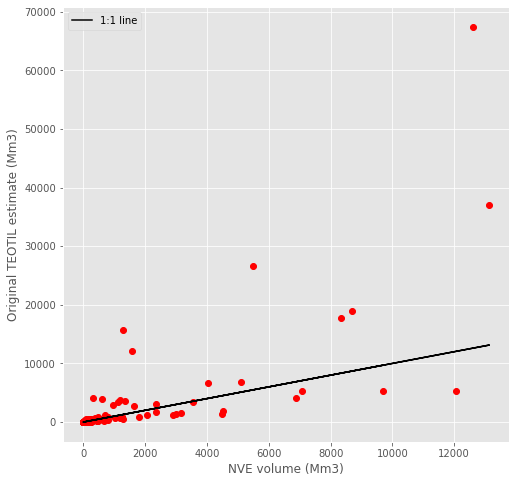

In [13]:
# Compare the original method with measured volumes
stats_df["orig_vol_Mm3"] = 1.8 * stats_df["area_km2"] ** 2 + 13 * stats_df["area_km2"]

# Calculate RMSE
orig_rmse = mean_squared_error(
    stats_df["vol_Mm3"], stats_df["orig_vol_Mm3"], squared=False
)
print(f"RMSE for original TEOTIL volume estimates: {orig_rmse:.0f} Mm3.")

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(stats_df["vol_Mm3"], stats_df["orig_vol_Mm3"], "ro")
ax.plot(stats_df["vol_Mm3"], stats_df["vol_Mm3"], "k-", label="1:1 line")
ax.set_xlabel("NVE volume (Mm3)")
ax.set_ylabel("Original TEOTIL estimate (Mm3)")
ax.legend(loc="upper left")

Based on the above plot, it is clear that **the original method tends to overestimate lake volumes**. Hopefully we can do better.

#### 1.4.2. Self-affine surfaces

There are broad theoretical reasons to consider landscapes as **self-affine surfaces**, which implies that the volume of a depression will be proportional to the depressional surface area raised to some exponent (see e.g. [Delaney et al., 2022](https://www.frontiersin.org/articles/10.3389/frwa.2022.886964/full) for an overview)

$$V = \beta_0 A^{\beta_1}$$

Such a model can be fitted using log-log linear regression.

Note that this model includes $V \propto A$ as a special case (where $\beta_1 = 1$), so it is not necessary to consider a simple linear model separately. Furthermore, if I try the argument `formula="vol_Mm3 ~ area_km2"` in the code below (instead of the logged version), the residuals from the regression are non-Normal and show obvious heteroscedasticity. In other words, using a log-transformation can be justified from both physical and statistical points of view. However, using log-transformation also incurs bias that should be corrected before making predictions. See the code and links [here](https://nbviewer.org/github/JamesSample/martini/blob/master/notebooks/process_norway_chem.ipynb#3.-Concentration-discharge-relationships) for a full explantion of the bias correction applied below.

                            OLS Regression Results                            
Dep. Variable:      np.log10(vol_Mm3)   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     3453.
Date:                Fri, 12 Aug 2022   Prob (F-statistic):          6.14e-195
Time:                        10:30:21   Log-Likelihood:                -113.48
No. Observations:                 389   AIC:                             231.0
Df Residuals:                     387   BIC:                             238.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.0837      0

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


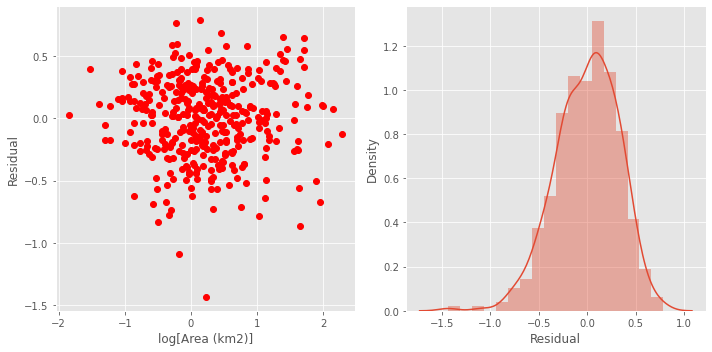

In [14]:
# log-log linear regression
mod = smf.ols(formula="np.log10(vol_Mm3) ~ np.log10(area_km2)", data=stats_df)
# mod = smf.ols(formula="vol_Mm3 ~ area_km2", data=stats_df)
res = mod.fit()
print(res.summary())

# Plot diagnotsics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].plot(res.model.exog[:, 1], res.resid, "ro")
axes[0].set_xlabel("log[Area (km2)]")
axes[0].set_ylabel("Residual")
sn.distplot(res.resid.values, ax=axes[1])
axes[1].set_xlabel("Residual")
plt.tight_layout()

$R^2$ for this regression (in the log space) is slight over 90% and the residuals are more-or-less normal. This seems like a promising start. The code belwos transfroms the predictions back to the unlogged scale, applies bias correction, and then computes the RMSE for comparison with the original TEOTIL approach.

RMSE for self-affine volume estimates: 1008 Mm3.


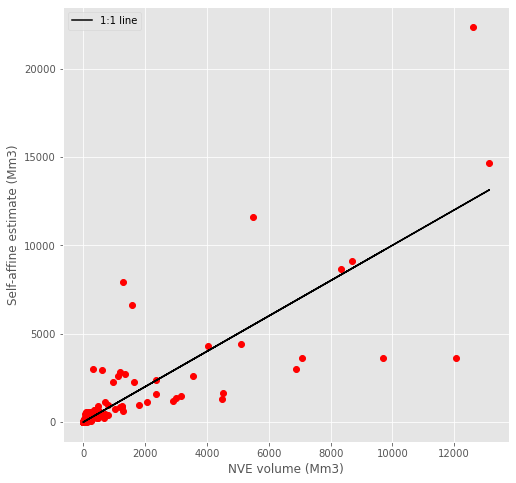

In [15]:
# Bias correction
beta_0 = 10 ** res.params[0]
beta_1 = res.params[1]
bias_fac = np.exp(2.651 * ((res.resid.values) ** 2).mean())

# Get fitted values
stats_df["sa_vol_Mm3"] = beta_0 * bias_fac * (stats_df["area_km2"] ** beta_1)

# Calculate RMSE
sa_rmse = mean_squared_error(stats_df["vol_Mm3"], stats_df["sa_vol_Mm3"], squared=False)
print(f"RMSE for self-affine volume estimates: {sa_rmse:.0f} Mm3.")

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(stats_df["vol_Mm3"], stats_df["sa_vol_Mm3"], "ro")
ax.plot(stats_df["vol_Mm3"], stats_df["vol_Mm3"], "k-", label="1:1 line")
ax.set_xlabel("NVE volume (Mm3)")
ax.set_ylabel("Self-affine estimate (Mm3)")
ax.legend(loc="upper left")

The plot above looks better than for the original TEOTIL method and the RMSE has reduced by a factor of more than 10, which is good.

#### 1.4.3. Lake aspect ratio

                            OLS Regression Results                            
Dep. Variable:      np.log10(vol_Mm3)   R-squared:                       0.908
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                     1897.
Date:                Fri, 12 Aug 2022   Prob (F-statistic):          2.18e-200
Time:                        10:30:22   Log-Likelihood:                -96.502
No. Observations:                 389   AIC:                             199.0
Df Residuals:                     386   BIC:                             210.9
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
Intercept                  1

/opt/conda/lib/python3.9/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


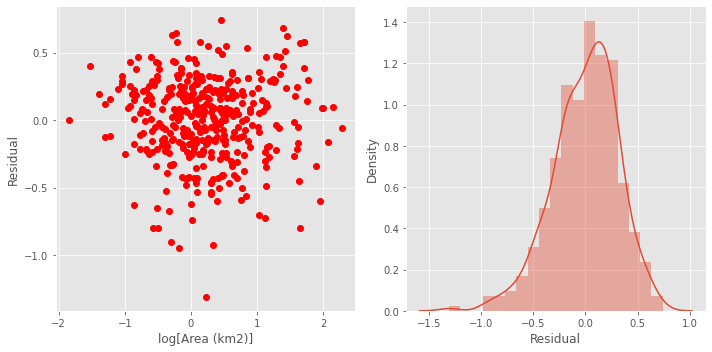

In [16]:
# log-log linear regression
mod = smf.ols(
    formula="np.log10(vol_Mm3) ~ np.log10(area_km2) + np.log10(aspect_ratio)",
    data=stats_df,
)
res = mod.fit()
print(res.summary())

# Plot diagnotsics
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
axes[0].plot(res.model.exog[:, 1], res.resid, "ro")
axes[0].set_xlabel("log[Area (km2)]")
axes[0].set_ylabel("Residual")
sn.distplot(res.resid.values, ax=axes[1])
axes[1].set_xlabel("Residual")
plt.tight_layout()

RMSE for self-affine volume estimates with aspect ratio included: 852 Mm3.


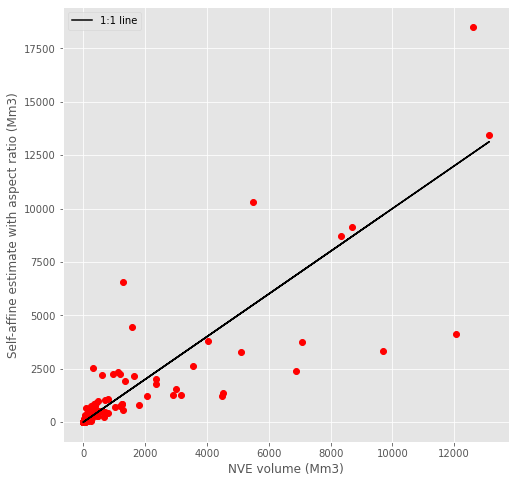

In [17]:
# Bias correction
beta_0 = 10 ** res.params[0]
beta_1 = res.params[1]
beta_2 = res.params[2]
bias_fac = np.exp(2.651 * ((res.resid.values) ** 2).mean())

# Get fitted values
stats_df["sa_asp_vol_Mm3"] = (
    beta_0
    * bias_fac
    * (stats_df["area_km2"] ** beta_1)
    * (stats_df["aspect_ratio"] ** beta_2)
)

# Calculate RMSE
sa_asp_rmse = mean_squared_error(
    stats_df["vol_Mm3"], stats_df["sa_asp_vol_Mm3"], squared=False
)
print(
    f"RMSE for self-affine volume estimates with aspect ratio included: {sa_asp_rmse:.0f} Mm3."
)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(stats_df["vol_Mm3"], stats_df["sa_asp_vol_Mm3"], "ro")
ax.plot(stats_df["vol_Mm3"], stats_df["vol_Mm3"], "k-", label="1:1 line")
ax.set_xlabel("NVE volume (Mm3)")
ax.set_ylabel("Self-affine estimate with aspect ratio (Mm3)")
ax.legend(loc="upper left")

#### 1.4.4. Terrain characteristics

In [18]:
def best_subsets_ols_regression(df, resp_var, exp_vars, standardise=False):
    """Performs all possible regressions involving exp_vars and returns the one with
    the lowest AIC.
    NOTE: This approach is generally a poor choice, since repeatedly comparing
    many models leads to problems with "multiple comparisons" and essentially
    invalidates any p-values. Use with caution!
    Also note that performance will be poor with many 'exp_vars', because this
    function performs an exhaustive search of all possible combinations (rather
    than just some, as with e.g. stepwise regression).
    Args:
        df:          Dataframe
        resp_var:    Str. Response variable. Column name in 'df'
        exp_vars:    List of str. Explanatory variables. Column names in 'df'
        standardise: Bool. Whether to standardise the 'exp_vars' by subtracting the
                     mean and dividing by the standard deviation
    Returns:
        Tuple (model_result_object, scalar). A residuals plot is also shown. The
        result object is for the "best" model found; the 'scalar' is a scikit-learn
        StandardScaler() object that can be used to transform new data for use with
        the returned model.
    """
    y = df[[resp_var]]
    X = df[exp_vars]

    scaler = StandardScaler()
    if standardise:
        X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

    aics = {}
    for k in range(1, len(exp_vars) + 1):
        for variables in itertools.combinations(exp_vars, k):
            preds = X[list(variables)]
            preds = sm.add_constant(preds)
            res = sm.OLS(y, preds).fit()
            aics[variables] = res.aic

    # Get the combination with lowest AIC
    best_vars = list(min(aics, key=aics.get))

    # Print regression results for these vars
    preds = X[list(best_vars)]
    preds = sm.add_constant(preds)
    res = sm.OLS(y, preds).fit()
    print("Regression results for the model with the lowest AIC:\n")
    print(res.summary())

    # Plot best AIC model and residuals
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    axes[0].plot(df[resp_var], res.fittedvalues, "ro")
    axes[0].plot(df[resp_var], df[resp_var], "k-")
    axes[0].set_xlabel("Observed", fontsize=16)
    axes[0].set_ylabel("Modelled", fontsize=16)

    sn.histplot(res.resid, ax=axes[1], kde=True)
    axes[1].set_xlabel("Residual", fontsize=16)
    axes[1].set_ylabel("Frequency", fontsize=16)

    plt.tight_layout()

    return (res, scaler)

Regression results for the model with the lowest AIC:

                            OLS Regression Results                            
Dep. Variable:                vol_Mm3   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                     1652.
Date:                Fri, 12 Aug 2022   Prob (F-statistic):          1.85e-240
Time:                        10:30:23   Log-Likelihood:                 4.6520
No. Observations:                 389   AIC:                            0.6960
Df Residuals:                     384   BIC:                             20.51
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------

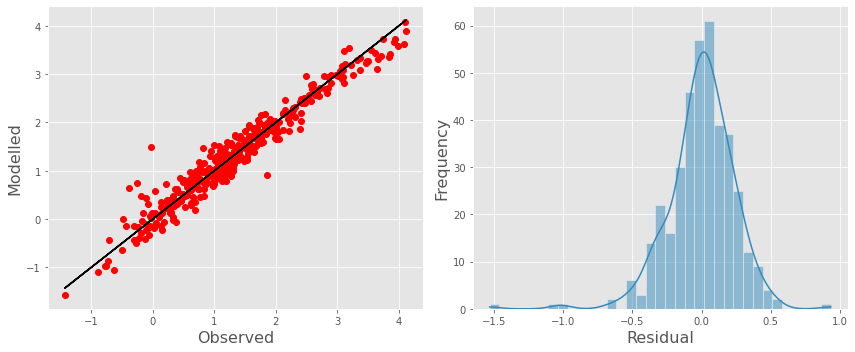

In [19]:
resp_var = "vol_Mm3"
exp_vars = [
    "area_km2",
    # "width_m",
    # "length_m",
    "aspect_ratio",
    "slp_mean",
    #    "slp_max",
    #    "dem_mean",
    #    "dem_max",
    "delta_elev",
]
df = np.log10(stats_df[[resp_var] + exp_vars])
res, scaler = best_subsets_ols_regression(df, "vol_Mm3", exp_vars, standardise=False)

RMSE for self-affine volume estimates with terrain characteristics and aspect ratio included: 685 Mm3.


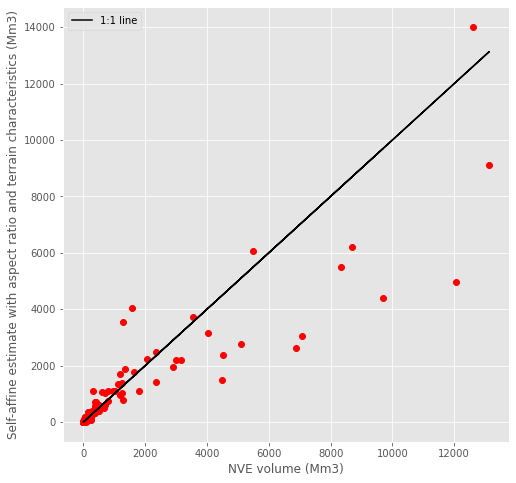

In [20]:
# Bias correction
beta_0 = 10 ** res.params[0]
bias_fac = np.exp(2.651 * ((res.resid.values) ** 2).mean())

# Get fitted values
reg_vars = res.params.keys()[1:]
stats_df["terr_vol_Mm3"] = beta_0 * bias_fac
for reg_var in reg_vars:
    stats_df["terr_vol_Mm3"] = stats_df["terr_vol_Mm3"] * (
        stats_df[reg_var] ** res.params[reg_var]
    )

# Calculate RMSE
terr_rmse = mean_squared_error(
    stats_df["vol_Mm3"], stats_df["terr_vol_Mm3"], squared=False
)
print(
    f"RMSE for self-affine volume estimates with terrain characteristics and aspect ratio included: {terr_rmse:.0f} Mm3."
)

# Plot
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(stats_df["vol_Mm3"], stats_df["terr_vol_Mm3"], "ro")
ax.plot(stats_df["vol_Mm3"], stats_df["vol_Mm3"], "k-", label="1:1 line")
ax.set_xlabel("NVE volume (Mm3)")
ax.set_ylabel(
    "Self-affine estimate with aspect ratio and terrain characteristics (Mm3)"
)
ax.legend(loc="upper left")